In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix
from xgboost import XGBClassifier

In [2]:
df = pd.read_parquet('ST data.parquet')
data = df.copy()

In [3]:
# 数据量
len(df), len(df.date.unique()), len(df.code.unique())

(586213, 172, 5532)

In [4]:
# 查看数据统计信息
df_summary = pd.DataFrame(index=df.columns[2:], columns=['mean', 'std', 'min', 'max', 'Nan_num'])
df_summary['mean'] = df.iloc[:, 2:].mean()
df_summary['std'] = df.iloc[:, 2:].std()
df_summary['min'] = df.iloc[:, 2:].min()
df_summary['max'] = df.iloc[:, 2:].max()
df_summary['Nan_num'] = df.iloc[:, 2:].isna().sum()

In [5]:
df_summary.head()

,mean,std,min,max,Nan_num
net_profit,5.194375e+08,5.800263e+09,-5.886218e+10,3.614110e+11,0
eps,2.569885e-01,7.033493e-01,-2.478340e+01,4.993000e+01,334
gross_margin,2.871837e+01,5.895004e+01,-9.977290e+03,1.154333e+02,11949
net_margin,-9.240980e+01,2.059841e+04,-7.156098e+06,1.336865e+06,722
roe,2.677114e+00,1.069789e+02,-1.921003e+04,7.336719e+03,4440


In [6]:
df_summary.to_excel('factor summary.xlsx')

In [7]:
train, test = data[data.date <= '20231231'], data[data.date >= '20240101']
X_train, y_train = train.drop(['date', 'code', 'is_st'], axis=1), train['is_st']
X_test, y_test = test.drop(['date', 'code', 'is_st'], axis=1), test['is_st']
sampler = RandomOverSampler()
X_rsl, y_rsl = sampler.fit_resample(X_train, y_train)

parameters = {'n_estimators': 100, 'max_depth': 7, 'reg_alpha': 8, 'reg_lambda': 8, 'Gamma': 8}
model_xgb = XGBClassifier(n_estimators=100, max_depth=7, reg_alpha=8, reg_lambda=8, gamma=8,
                          objective="binary:logistic", eval_metric="auc", seed=123)
model_xgb.fit(X_rsl, y_rsl)
y_pred_xgb = model_xgb.predict(X_test)
y_pred_pr = model_xgb.predict_proba(X_test)

In [8]:
fpr_xgb, tpr_xgb, thr_xgb = roc_curve(y_test, y_pred_pr[:, 1])
auc_xgb = auc(fpr_xgb, tpr_xgb)
print("AUC Score: {}".format(auc_xgb))
mat = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1]


# 计算常用指标
def compute_indexes(tp, fp, tn, fn):
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = (2 * precision * recall) / (precision + recall)
    return accuracy, precision, recall, F1


compute_indexes(tp, fp, tn, fn)

AUC Score: 0.9692374075224549


(0.9510633325543352,
 0.35429344151453684,
 0.8506493506493507,
 0.5002386634844869)

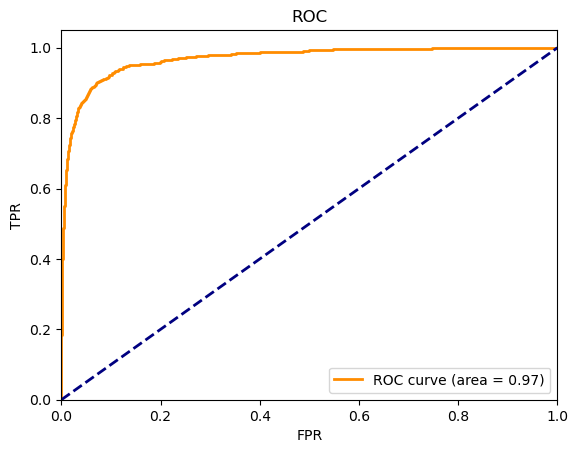

In [9]:
plt.figure()  
lw = 2  
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc_xgb)  
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('FPR')  
plt.ylabel('TPR')  
plt.title('ROC')  
plt.legend(loc="lower right")  
plt.show()

In [10]:
f1_score = np.zeros(50)
for p in np.arange(0.5, 1, 0.01):
    y_thr = y_pred_pr[:, 1].copy()
    y_thr[y_thr >= p] = 1
    y_thr[y_thr < p] = 0
    
    mat = confusion_matrix(y_test, y_thr)
    tn, fp, fn, tp = mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1]
    f1_score[int((p - 0.5) * 100)] = compute_indexes(tp, fp, tn, fn)[3]

In [11]:
np.argmax(f1_score)

36

In [12]:
y_thr = y_pred_pr[:, 1].copy()
y_thr[y_thr >= 0.91] = 1
y_thr[y_thr < 0.91] = 0

mat = confusion_matrix(y_test, y_thr)
tn, fp, fn, tp = mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1]
compute_indexes(tp, fp, tn, fn)

(0.9807899041832204,
 0.6880733944954128,
 0.6087662337662337,
 0.6459948320413437)

In [13]:
# 网格搜索寻找最优参数（示例）
parameters = {"learning_rate": [0.2, 0.25, 0.3], "n_estimators":range(80,101,10), "max_depth":range(7, 11, 1)}

xgb_grid = GridSearchCV(model_xgb, parameters, scoring="roc_auc", verbose=1)
xgb_grid.fit(X_rsl, y_rsl)
print("The best parameters are: ", xgb_grid.best_params_)
y_pred_bp = xgb_grid.predict_proba(X_test)
fpr_bp, tpr_bp, thr_bp = roc_curve(y_test, y_pred_bp[:, 1])
auc_bp = auc(fpr_bp, tpr_bp)
print("Test AUC of XGB after hyper-parameter tuning: {}".format(auc_bp))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
The best parameters are:  {'learning_rate': 0.25, 'max_depth': 10, 'n_estimators': 90}
Test AUC of XGB after hyper-parameter tuning: 0.9737062440663432


In [14]:
# 交叉验证结果，储存在cv_results中
cv_results = pd.DataFrame.from_dict(xgb_grid.cv_results_)

In [15]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.955316,0.162604,0.127360,0.009889,0.2,7,80,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti...",0.985869,0.976067,0.986614,0.994199,0.996880,0.987926,0.007295,36
1,4.148573,0.141368,0.121160,0.004078,0.2,7,90,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti...",0.987787,0.978396,0.987922,0.995103,0.997381,0.989318,0.006664,35
2,4.480073,0.134978,0.133707,0.014767,0.2,7,100,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti...",0.989126,0.980085,0.989450,0.995719,0.997807,0.990437,0.006198,34
3,4.473173,0.144037,0.118818,0.001471,0.2,8,80,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti...",0.990975,0.983722,0.991579,0.996512,0.998350,0.992228,0.005102,30
4,4.500639,0.133646,0.122130,0.002464,0.2,8,90,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti...",0.992276,0.985145,0.992710,0.997125,0.998632,0.993178,0.004709,27


In [16]:
f1_score = np.zeros(50)
for p in np.arange(0.5, 1, 0.01):
    y_thr = y_pred_bp[:, 1].copy()
    y_thr[y_thr >= p] = 1
    y_thr[y_thr < p] = 0
    
    mat = confusion_matrix(y_test, y_thr)
    tn, fp, fn, tp = mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1]
    f1_score[int((p - 0.5) * 100)] = compute_indexes(tp, fp, tn, fn)[3]

In [17]:
f1_score

array([0.60222613, 0.60854093, 0.61234272, 0.6128838 , 0.61838101,
       0.62315271, 0.62882096, 0.63390044, 0.64076433, 0.64774194,
       0.65191932, 0.6530343 , 0.65643763, 0.65863454, 0.66261808,
       0.66303608, 0.66620785, 0.66897988, 0.67131891, 0.67368421,
       0.67806268, 0.6795977 , 0.68317553, 0.68424908, 0.68639053,
       0.68754661, 0.69022556, 0.68986384, 0.69101979, 0.69166029,
       0.69511249, 0.69278997, 0.70047544, 0.70127796, 0.70265915,
       0.69983687, 0.69744435, 0.69391159, 0.6893617 , 0.68571429,
       0.68006993, 0.68092692, 0.67870036, 0.66297322, 0.65657521,
       0.64410058, 0.62772277, 0.60878447, 0.57417289, 0.5132336 ])

In [18]:
np.argmax(f1_score)

34

In [19]:
y_thr = y_pred_bp[:, 1].copy()
y_thr[y_thr >= 0.89] = 1
y_thr[y_thr < 0.89] = 0

mat = confusion_matrix(y_test, y_thr)
tn, fp, fn, tp = mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1]
compute_indexes(tp, fp, tn, fn)

(0.9830334190231362,
 0.7346938775510204,
 0.6428571428571429,
 0.6857142857142857)

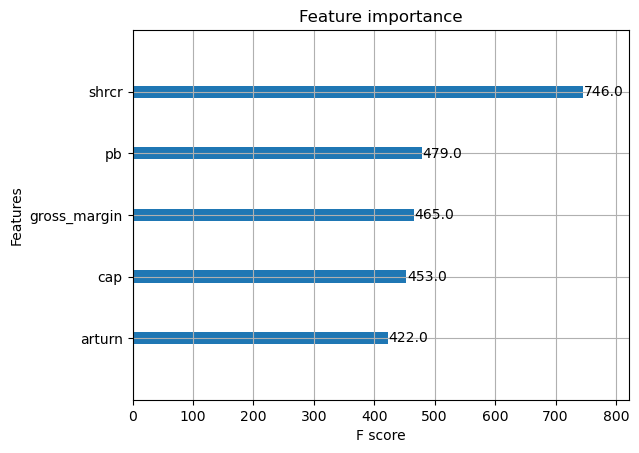

In [20]:
# 绘制特征重要性排序
xgb.plot_importance(model_xgb, max_num_features=5)
plt.show()

In [21]:
xgb_importance = model_xgb.feature_importances_(type)
print(xgb_importance)

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
xgb.plot_tree(model_xgb, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')